# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [1]:
%pip install keras-tuner scikit-image -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

import os
import shutil

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [3]:
# Load the dataset training and test sets as numpy arrays
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

#normalize the data
X_train = X_train / 255
X_test = X_test / 255

# convert images to grayscale for feature extraction
X_train_gray = np.array([rgb2gray(image) for image in X_train])
X_test_gray = np.array([rgb2gray(image) for image in X_test])

#convert labels to one-hot encoding
y_train_onehot = keras.utils.to_categorical(y_train, 9)
y_test_onehot = keras.utils.to_categorical(y_test, 9)

#split training sets into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_gray, X_val_gray, y_train_onehot, y_val_onehot = train_test_split(X_train_gray, y_train_onehot, test_size=0.2, random_state=42)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

X_train shape: (25600, 28, 28, 3)
X_train_gray shape: (25600, 28, 28)
y_train shape: (25600,)
y_train examples: [5 6 7 6 8]
y_train_onehot shape: (25600, 9)
y_train_onehot examples: [[0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


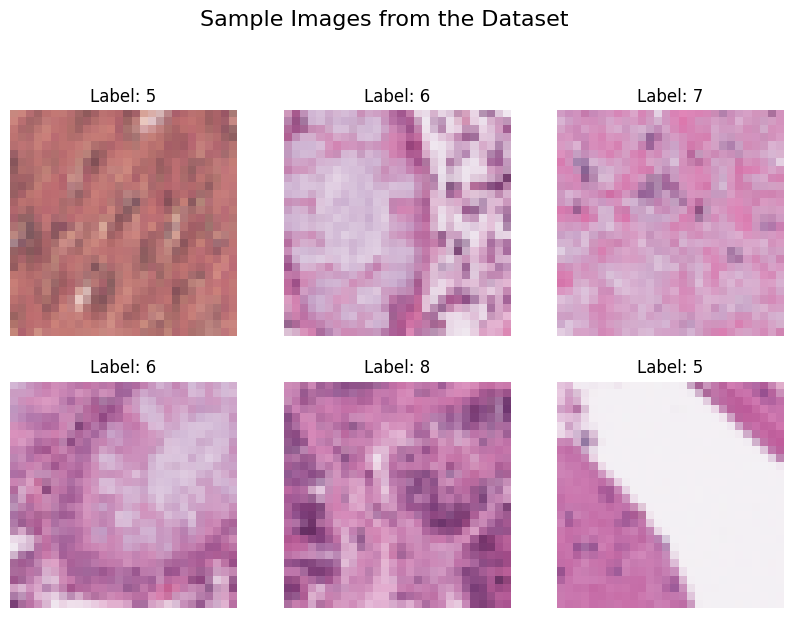

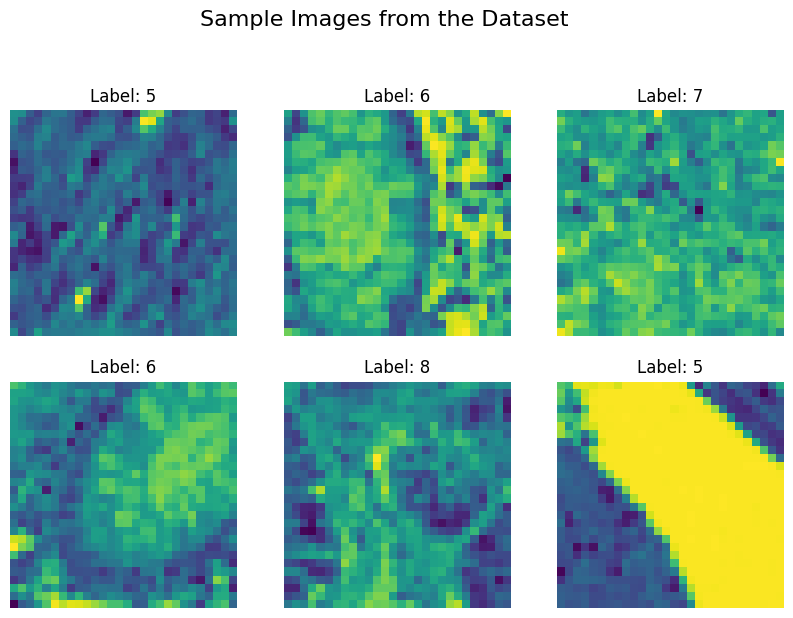

In [4]:
print("X_train shape:", X_train.shape)
print("X_train_gray shape:", X_train_gray.shape)
print("y_train shape:", y_train.shape)
print("y_train examples:", y_train[:5])
print("y_train_onehot shape:", y_train_onehot.shape)
print("y_train_onehot examples:" , y_train_onehot[:5])

def plot_images(title, dataset:np.ndarray, labels:np.ndarray, num_images:int=6):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(dataset[i])
        plt.axis('off')
        plt.title(f"Label: {labels[i]}")
    plt.suptitle('Sample Images from the Dataset', fontsize=16)
    plt.show()

plot_images('Sample Color Images', X_train, y_train, num_images=6)
plot_images('Sample Grayscale images', X_train_gray, y_train, num_images=6)


In [5]:
print("X_train shape:", X_train.shape)
print("X_train_gray shape:", X_train_gray.shape)
print("y_train shape:", y_train.shape)
print("y_train examples:", y_train[:5])
print("y_train_onehot shape:", y_train_onehot.shape)

X_train shape: (25600, 28, 28, 3)
X_train_gray shape: (25600, 28, 28)
y_train shape: (25600,)
y_train examples: [5 6 7 6 8]
y_train_onehot shape: (25600, 9)


## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [6]:
X_train_gray_1D = X_train_gray.reshape(len(X_train_gray), 28*28)
X_test_gray_1D = X_test_gray.reshape(len(X_test), 28*28)
X_val_gray_1D = X_val_gray.reshape(len(X_val_gray), 28*28)

print("Train", X_train_gray_1D.shape, X_test_gray_1D.shape, X_val_gray_1D.shape)

print("Test", y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape)

Train (25600, 784) (8000, 784) (6400, 784)
Test (25600, 9) (6400, 9) (8000, 9)


In [ ]:
X_train_processed = X_train_gray_1D
X_val_processed = X_val_gray_1D
X_test_processed = X_test_gray_1D

# Check target array's formatting
if len(np.unique(y_train_onehot)) <= 1 or len(np.unique(y_val_onehot)) <= 1 or len(np.unique(y_test_onehot)) <= 1:
    raise ValueError("Target arrays have only one class or are improperly formatted.")


# random forest
name = "Random Forest"
model = RandomForestClassifier(n_estimators=100, random_state=42)

try:
    # Train the model
    model.fit(X_train_processed, np.argmax(y_train_onehot, axis=1))

    # Evaluate on training set
    train_preds = model.predict(X_train_processed)
    train_score = accuracy_score(np.argmax(y_train_onehot, axis=1), train_preds)
    print(f"{name} - Accuracy on training set: {train_score:.3f}")

    # Evaluate on validation set
    val_preds = model.predict(X_val_processed)
    val_score = accuracy_score(np.argmax(y_val_onehot, axis=1), val_preds)
    print(f"{name} - Accuracy on validation set: {val_score:.3f}")

    # Evaluate on test set
    test_preds = model.predict(X_test_processed)
    test_score = accuracy_score(np.argmax(y_test_onehot, axis=1), test_preds)
    print(f"{name} - Accuracy on test set: {test_score:.3f}\n")

except Exception as e:
    print(f"Error in {name}: {e}\n")


Random Forest - Accuracy on training set: 1.000
Random Forest - Accuracy on validation set: 0.513
Random Forest - Accuracy on test set: 0.520



### Fully connected neural network

In [ ]:
def build_fc_model(hp):
    """Builds a fully connected model with tunable hyperparametes."""

    # tunable hyperparameters
    num_layers = hp.Int('num_layers', min_value=2, max_value=5)
    num_units = hp.Int('num_units', min_value=64, max_value=512, step=64)
    dropout_rate = hp.Float('dropout_rate', 0, 0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    
    model = keras.models.Sequential([
        keras.layers.Input(shape=(28, 28, 3)),
        keras.layers.Flatten(),
    ])

    for _ in range(num_layers):
        model.add(keras.layers.Dense(units=num_units, activation='relu'
        ))
        model.add(keras.layers.Dropout(rate=dropout_rate))
    
    model.add(keras.layers.Dense(units=9, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Convolutional neural network

In [54]:

def build_cnn_model(hp: kt.HyperParameters) -> keras.Model:
    """BUilds CNN model with tunable hyperparameters."""

    #Tunable hyperparameters
    conv_blocks   = hp.Int('conv_blocks', 2, 4)
    filters_start = hp.Choice('filters_start',[8, 16, 32]) 
    kernel_size   = hp.Choice('kernel_size', [3, 5])
    pool_type     = hp.Choice('pool_type', ['max', 'avg'])
    dropout_rate  = hp.Float('dropout_rate', 0.0, 0.5, step=0.25)
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28, 3)))

    # convolutional blocks
    for b in range(conv_blocks):
        filters = filters_start * 2**b                         # 32→64→128 …
        model.add(keras.layers.Conv2D(filters, kernel_size,
                                padding='same', activation='relu'))
        model.add(keras.layers.Conv2D(filters, kernel_size,
                                padding='same', activation='relu'))
        if pool_type == 'max':
            model.add(keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
        else:
            model.add(keras.layers.AveragePooling2D(pool_size=2, strides=2))
        model.add(keras.layers.Dropout(dropout_rate))

    # transition to dense head
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(9, activation='softmax'))

    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## 3. Hyperparameter tuning

In [ ]:
def tune_nn_model(model, model_type: str):
    """Tune the neural network model using Keras Tuner. 
    Args:
        model: The model to be tuned.
        model_type: The type of the model (e.g., 'fc', 'cnn', etc.)."""

    # Set up the log directory for TensorBoard
    log_dir =f'tuning_logs/{model_type}'
    if os.path.exists(log_dir):
        # Remove the previous log directory if it exists
        shutil.rmtree(log_dir, ignore_errors=True)
    os.makedirs(log_dir)

    # Remove the previous keras_tuner directory if it exists
    if os.path.exists('keras_tuner'):
        shutil.rmtree('keras_tuner', ignore_errors=True)

    # Define the hypermodel
    tuner = kt.Hyperband(
        model,
        objective='val_accuracy',
        max_epochs=10,
        factor=2,
        directory='keras_tuner',
        project_name=model_type,
    )
    # TensorBoard callback for logging and visualization of the tuning process
    tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) 
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Start the parameter search
    tuner.search_space_summary()
    tuner.search(
        X_train, y_train_onehot,
        epochs=30,
        validation_data=(X_val, y_val_onehot),
        verbose=1,
        callbacks=[tensorboard, early_stopping],
    )

    # Get the best hyperparameters and build the best model
    best_params = tuner.get_best_hyperparameters()[0]
    best_model = tuner._build_hypermodel(best_params)
    
    tuner.results_summary(num_trials=1)
    
    return best_model, best_params


### Algorithm of choice from first six weeks of course

In [ ]:
# Ensure you're using the same features for training and evaluation
X_train_processed = X_train_gray_1D
X_val_processed = X_val_gray_1D
X_test_processed = X_test_gray_1D

# Check if target arrays are properly formatted
if len(np.unique(y_train_onehot)) <= 1 or len(np.unique(y_val_onehot)) <= 1 or len(np.unique(y_test_onehot)) <= 1:
    raise ValueError("Target arrays have only one class or are improperly formatted.")

# Hyperparameter tuning for Random Forest using RandomizedSearchCV
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_random_search.fit(X_train_processed, np.argmax(y_train_onehot, axis=1))

print("Best Random Forest Parameters:", rf_random_search.best_params_)
print("Best Random Forest Training Accuracy:", rf_random_search.best_score_)

# Train the best model
best_rf = rf_random_search.best_estimator_
best_rf.fit(X_train_processed, np.argmax(y_train_onehot, axis=1))

# Evaluate on training set
train_preds = best_rf.predict(X_train_processed)
train_score = accuracy_score(np.argmax(y_train_onehot, axis=1), train_preds)
print(f"Random Forest - Accuracy on training set: {train_score:.3f}")

# Evaluate on validation set
val_preds = best_rf.predict(X_val_processed)
val_score = accuracy_score(np.argmax(y_val_onehot, axis=1), val_preds)
print(f"Random Forest - Accuracy on validation set: {val_score:.3f}")

# Evaluate on test set
test_preds = best_rf.predict(X_test_processed)
test_score = accuracy_score(np.argmax(y_test_onehot, axis=1), test_preds)
print(f"Random Forest - Accuracy on test set: {test_score:.3f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.9min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.9min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 1.9min
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.6min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.

In [44]:
# Save the best model
import joblib

model_path = 'best_models/best_random_forest_model.pkl'
joblib.dump(best_rf, model_path)
print(f"Model saved at {model_path}")

Model saved at best_models/best_random_forest_model.pkl


### Fully connected neural network

In [44]:
# tune the model to find the best hyperparameters
best_model, best_params = tune_nn_model(build_fc_model, 'fc')

# train the best model
best_model.fit(
    X_train, y_train_onehot,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, y_val_onehot),
    verbose=1
)

# evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)

best_model.save('best_models/best_fc_model.keras')
best_model.summary()

Trial 46 Complete [00h 00m 26s]
val_accuracy: 0.4867187440395355

Best val_accuracy So Far: 0.5882812738418579
Total elapsed time: 00h 11m 28s
Results summary
Results in keras_tuner/fc
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0044 summary
Hyperparameters:
num_layers: 5
num_units: 448
dropout_rate: 0.0
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.5882812738418579
Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2853 - loss: 1.8667 - val_accuracy: 0.4080 - val_loss: 1.5760
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4164 - loss: 1.5486 - val_accuracy: 0.3572 - val_loss: 1.7281
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4627 - loss: 1.4201 - val_accuracy: 0.3570 - val_loss: 1.6995
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4852 - loss: 1.3741 - val_accuracy: 0.5234 - val_loss: 1.2723
Epoch 5/10
1600/1

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 448)            │     1,054,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 448)            │       201,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 448)            │       201,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 448)            │       201,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 448)            │       201,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         4,041 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,588,381 (21.32 MB)

 Trainable params: 1,862,793 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,725,588 (14.21 MB)

### Convolutional neural network

In [55]:
# tune the model to find the best hyperparameters
best_model, best_params = tune_nn_model(build_cnn_model, 'cnn')

# train the best model
best_model.fit(
    X_train, y_train_onehot,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, y_val_onehot),
    verbose=1
)

# evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)

best_model.save('best_models/best_cnn_model.keras')
best_model.summary()

Trial 46 Complete [00h 02m 31s]
val_accuracy: 0.7237499952316284

Best val_accuracy So Far: 0.8304687738418579
Total elapsed time: 00h 49m 38s
Results summary
Results in keras_tuner/cnn
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0018 summary
Hyperparameters:
conv_blocks: 3
filters_start: 32
kernel_size: 3
pool_type: max
dropout_rate: 0.0
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 5
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0015
Score: 0.8304687738418579
Epoch 1/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.7697 - loss: 0.6271 - val_accuracy: 0.7895 - val_loss: 0.5575
Epoch 2/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.7896 - loss: 0.5672 - val_accuracy: 0.8016 - val_loss: 0.5461
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8151 - loss: 0.5032 - val_accuracy: 0.7691 - val_loss: 0.6423
Epoch 4/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8376 - loss: 0.4502 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,307,261 (4.99 MB)

 Trainable params: 435,753 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 871,508 (3.32 MB)

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

In [ ]:
# Load the saved model
model_path = 'best_models/best_random_forest_model.pkl'

params = {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}

best_rf = RandomForestClassifier(**params)
best_rf.fit(X_train_processed, np.argmax(y_train_onehot, axis=1))

# Example inference
def predict(input_data):
    """
    Predicts the class for the given input data using the loaded Random Forest model.
    
    Parameters:
        input_data (numpy array): The processed input data for prediction.
    
    Returns:
        predicted_class (int): The predicted class label.
    """
    if best_rf:
        prediction = best_rf.predict(input_data)
        return prediction
    else:
        print("Model not loaded properly.")
        return None


# Evaluate on training set
train_preds = best_rf.predict(X_train_processed)
train_score = accuracy_score(np.argmax(y_train_onehot, axis=1), train_preds)
print(f"Random Forest - Accuracy on training set: {train_score:.3f}")

# Evaluate on validation set
val_preds = best_rf.predict(X_val_processed)
val_score = accuracy_score(np.argmax(y_val_onehot, axis=1), val_preds)
print(f"Random Forest - Accuracy on validation set: {val_score:.3f}")

# Evaluate on test set
test_preds = best_rf.predict(X_test_processed)
test_score = accuracy_score(np.argmax(y_test_onehot, axis=1), test_preds)
print(f"Random Forest - Accuracy on test set: {test_score:.3f}")


Random Forest - Accuracy on training set: 0.991
Random Forest - Accuracy on validation set: 0.551
Random Forest - Accuracy on test set: 0.553


### Fully connected neural network

In [60]:
fc_model = keras.models.load_model('best_models/best_fc_model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = fc_model.evaluate(X_test, y_test_onehot)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5857 - loss: 1.0610
Test Loss: 1.0652
Test Accuracy: 0.5854


### Convolutional neural network

In [56]:
fc_model = keras.models.load_model('best_models/best_cnn_model.keras')

# Evaluate the model on the test set
test_loss, test_accuracy = fc_model.evaluate(X_test, y_test_onehot)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8594 - loss: 0.4226
Test Loss: 0.4303
Test Accuracy: 0.8577
